In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [12]:
# function for calculating the correlation between two variables
def get_corr(a, b, pr=3):
    corr = pearsonr(a, b)[0]
    corr = np.round(corr, pr)
    return str(corr)


# function for calculating the R2 score and RMSE
def eval_model(predictions, log_predictions, model):
    r2 = r2_score(orig_y_test, predictions)
    r2_log = r2_score(log_y_test, log_predictions)
    rmse = np.sqrt(mean_squared_error(orig_y_test, predictions))
    rmse_log = np.sqrt(mean_squared_error(log_y_test, log_predictions))
    
    print('R2 score on test set: %.3f\n' % r2)
    print('R2 score on test set (log-transformed): %.3f\n' % r2_log)
    print('RMSE on test set: %.3f\n' % rmse)
    print('RMSE on test set (log_transformed): %.3f\n' % rmse_log)


# function for printing the equation created by the linear regression model
def print_equation(model, pr=3):
    coefs = np.round(model.coef_, pr)
    intercept = np.round(model.intercept_, pr)
    equation = 'Model equation:\n' 
    equation += 'N100 =' if not log_transf_n100 else 'N100_log ='
    
    # adding the coefficients one after another
    for i in range(len(coefs)):
        if coefs[i] < 0:
            equation += ' - '
        elif i == 0:
            equation += ' '
        else:
            equation += ' + '
        
        equation += str(np.abs(coefs[i]))
        equation += '*' + predictors[i]
    
    # adding the intercept
    if intercept < 0:
        equation += ' - '
    else:
        equation += ' + '
        
    equation += str(np.abs(intercept)) + '\n'               
    print(equation)

    
# function for plotting the observed and predicted n100 concentrations against each other
def corr_eval(predictions, log_transf=False):
    observations = orig_y_test if not log_transf else log_y_test
    corr = get_corr(observations, predictions)
    axis_min, axis_max = int(observations.min()), int(observations.max())
    
    plt.figure(figsize=(5, 5))
    plt.plot(np.arange(axis_min, axis_max+1), np.arange(axis_min, axis_max+1), c='black', alpha=0.25)
    plt.scatter(observations, predictions, s=2, alpha=0.5)
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    if log_transf:
        plt.title('Observed vs. Predicted N100 Concentration (log-transformed)')
        print('Correlation between observed and predicted N100 concentration (log-transformed): '+corr+'\n')
    else:
        plt.title('Observed vs. Predicted N100 Concentration')
        print('Correlation between observed and predicted N100 concentration: '+corr+'\n')
    
    
# function for plotting observed and predicted n100 concentrations (log-scale)
def plot_results(name, predictions, data):
    plt.figure(figsize=(15, 5))
    plt.title('Performance of ' + name + ' Model - Whole Dataset')
    plt.plot(data.n100_log, label='Observed')
    plt.plot(predictions, label='Predicted', alpha=0.75)
    plt.xlabel('Timestep')
    plt.ylabel('N100 Concentration (log-transformed)')
    plt.ylim(-2, 12)
    plt.legend()
    

# function for plotting the residuals of the predicted n100 concentrations (log-scale)
def plot_residuals(name, predictions, data):
    plt.figure(figsize=(15, 5))
    plt.title('Residual of Predictions for ' + name + ' Model - Whole Dataset')
    plt.plot(np.abs(data.n100_log - predictions), c='green', alpha=0.75)
    plt.xlabel('Timestep')
    plt.ylabel('N100 Concentration (log-transformed)')
    plt.ylim(0, 5)

In [4]:
cities = ['ABZ', 'ALE', 'AMA', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'DEL', 'EGB',
          'HAD', 'HEL', 'HPB', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 'MLP', 'MUK', 
          'NAN', 'NEU', 'POV', 'SAO', 'SCH', 'SGP', 'UAE', 'VAR', 'VIE', 'WAL', 
          'ZOT']

variables = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 'aermr07', 
             'aermr08', 'aermr09', 'aermr10', 'co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 
             'so2', 'd2m', 't2m', 'crwc', 'blh', 'rh', 'doy_sin', 'doy_cos', 'latitude', 
             'longitude_sin', 'longitude_cos']

dont_transform = ['d2m', 't2m', 'blh', 'rh', 'doy_sin', 'doy_cos', 'latitude', 'longitude_sin', 'longitude_cos']

predictors = []
for v in variables:    
    if v in dont_transform:
        predictors.append(v)
    else:
        predictors.append(v+'_log')

In [5]:
data = pd.read_csv('data/full_data.csv', parse_dates=['date'])

for v in ['n100']+variables:
    if v not in dont_transform:
        transformed = data[v]
        transformed = transformed.where(transformed != transformed.min(), transformed.nlargest(2).iloc[-1])
        data[v+'_log'] = np.log(transformed)
        
data.head()

,id,station,date,doy_sin,doy_cos,latitude,longitude_sin,longitude_cos,n100,aermr01,...,aermr09_log,aermr10_log,co_log,c5h8_log,c10h16_log,nh3_log,no_log,no2_log,so2_log,crwc_log
0,ABZ-2012-01-26,ABZ,2012-01-26,0.431673,0.902030,0.561889,0.438057,0.898947,2708.085714,6.752697e-12,...,-22.383946,-21.309149,-14.888857,-24.715712,-22.277308,-20.891909,-18.156078,-17.697916,-18.856889,-9.139102
1,ABZ-2012-01-27,ABZ,2012-01-27,0.447094,0.894487,0.561889,0.438057,0.898947,2489.175000,4.223335e-12,...,-22.018130,-21.181645,-14.786466,-24.526129,-22.109902,-20.714570,-18.022533,-17.632291,-18.761336,-9.139102
2,ABZ-2012-01-28,ABZ,2012-01-28,0.462383,0.886680,0.561889,0.438057,0.898947,3484.229167,3.553853e-12,...,-21.523018,-20.943542,-14.472229,-24.080899,-21.518834,-20.381543,-17.223582,-17.785600,-18.708921,-9.139102
3,ABZ-2012-01-29,ABZ,2012-01-29,0.477536,0.878612,0.561889,0.438057,0.898947,2977.512500,8.665312e-12,...,-21.433621,-21.326093,-14.977114,-25.068593,-22.885339,-20.340459,-19.236020,-17.969860,-19.128033,-9.139102
4,ABZ-2012-01-30,ABZ,2012-01-30,0.492548,0.870285,0.561889,0.438057,0.898947,2702.463636,1.436837e-11,...,-21.482813,-21.669206,-15.236442,-25.461374,-23.836271,-20.333199,-20.702253,-18.124264,-19.070916,-9.139102


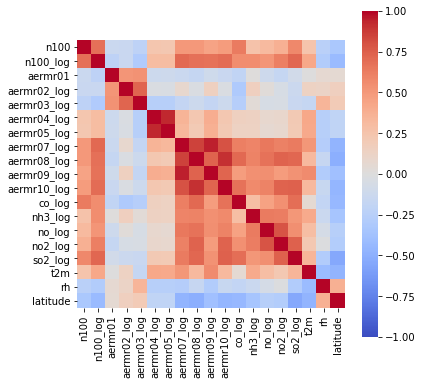

In [13]:
# use when using original n100 data
# predictors = ['aermr01', 'aermr02_log', 'aermr03_log', 'aermr04', 'aermr05', 'aermr06', 
#               'aermr07', 'aermr08', 'aermr09', 'aermr10', 'co', 'nh3', 'no', 'no2', 'so2', 
#               't2m', 'blh', 'rh', 'doy_sin', 'doy_cos', 'longitude_sin', 'longitude_cos']

# use when log-transforming n100 data
predictors = ['aermr01', 'aermr02_log', 'aermr03_log', 'aermr04_log', 'aermr05_log',
              'aermr07_log', 'aermr08_log', 'aermr09_log', 'aermr10_log', 'co_log',
              'nh3_log', 'no_log', 'no2_log', 'so2_log', 't2m', 'rh', 'latitude']

plt.figure(figsize=(6,6))
sns.heatmap(data[['n100', 'n100_log']+predictors].corr(), 
            xticklabels=['n100', 'n100_log']+predictors, yticklabels=['n100', 'n100_log']+predictors, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1);

In [14]:
# splitting the dataset into training (75%) and testing (25%) sets
indices = np.arange(len(data))
np.random.seed(42)
np.random.shuffle(indices)
split = int(len(indices) * 0.75)
train_indices = indices[:split]
test_indices = indices[split:]

# predictor variables
X_train = np.take(data[predictors], train_indices, 0)
X_test = np.take(data[predictors], test_indices, 0)

# n100 concentration
log_transf_n100 = True
y_train = np.take(data.n100, train_indices, 0) if not log_transf_n100 else np.take(data.n100_log, train_indices, 0)
log_y_test = np.take(data.n100_log, test_indices, 0)
orig_y_test = np.take(data.n100, test_indices, 0)
y_test = orig_y_test if not log_transf_n100 else log_y_test

print('Train set shapes:', X_train.shape, 'and', y_train.shape)
print('Test set shapes:', X_test.shape, 'and', y_test.shape)

Train set shapes: (36183, 17) and (36183,)
Test set shapes: (12061, 17) and (12061,)


Model equation:
N100_log = - 473840908.593*aermr01 - 0.048*aermr02_log - 0.046*aermr03_log - 0.008*aermr04_log + 0.013*aermr05_log - 0.101*aermr07_log + 0.038*aermr08_log + 0.337*aermr09_log + 0.01*aermr10_log + 0.039*co_log + 0.06*nh3_log - 0.03*no_log + 0.071*no2_log + 0.292*so2_log + 0.004*t2m + 0.0*rh + 0.339*latitude + 18.389

Correlation between observed and predicted N100 concentration: 0.699

Correlation between observed and predicted N100 concentration (log-transformed): 0.837

R2 score on test set: 0.470

R2 score on test set (log-transformed): 0.700

RMSE on test set: 1127.031

RMSE on test set (log_transformed): 0.642



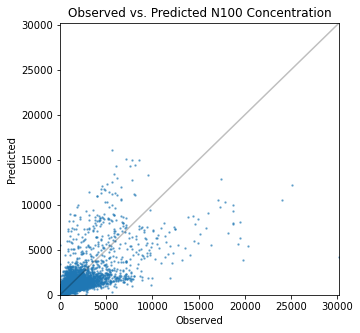

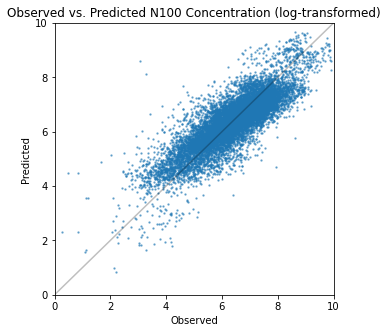

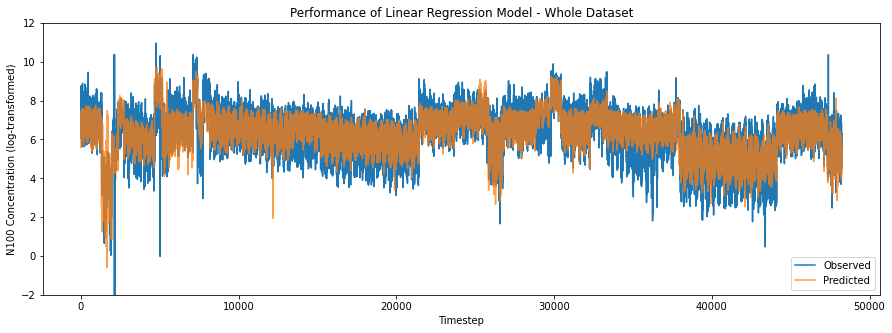

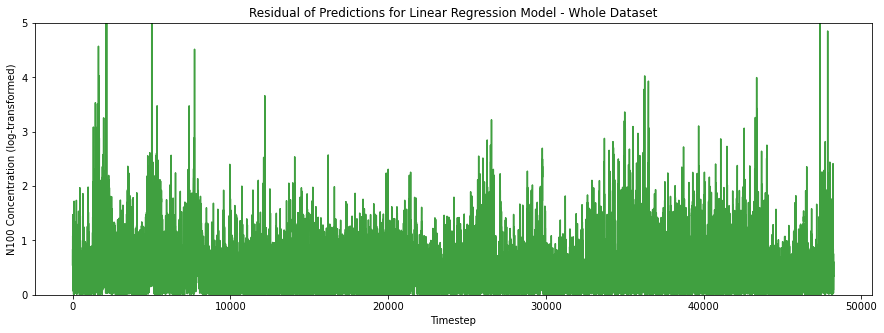

In [15]:
# fitting the linear regression model
model = LinearRegression().fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)
log_predictions = None
if log_transf_n100:
    log_predictions = predictions
    predictions = np.exp(predictions)
    predictions[predictions <= 0] = 0.1
else:
    predictions[predictions <= 0] = 0.1
    log_predictions = np.log(predictions)

# printing the model evaluation
print_equation(model)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions)
corr_eval(log_predictions, log_transf=True)

# evaluating the model performance
eval_model(predictions, log_predictions, model)

# making predictions for the whole dataset
predictions_all = model.predict(np.array(data[predictors]))
if not log_transf_n100:
    predictions_all[predictions_all <= 0] = 0.1
    predictions_all = np.log(predictions_all)

# plotting the observed and predicted n100 concentrations against time in log-scale
plot_results('Linear Regression', predictions_all, data)
plot_residuals('Linear Regression', predictions_all, data)

# RESULTS:
# --------
# predictors for original data
# Correlation between observed and predicted N100 concentration: 0.81
# Correlation between observed and predicted N100 concentration (log-transformed): 0.612
# R2 score on test set: 0.656
# R2 score on test set (log-transformed): -0.596
# RMSE on test set: 908.677
# RMSE on test set (log_transformed): 1.480

# predictors for log-transformed data
# Correlation between observed and predicted N100 concentration: 0.699
# Correlation between observed and predicted N100 concentration (log-transformed): 0.837
# R2 score on test set: 0.470
# R2 score on test set (log-transformed): 0.700
# RMSE on test set: 1127.031
# RMSE on test set (log_transformed): 0.642

Correlation between observed and predicted N100 concentration: 0.896

Correlation between observed and predicted N100 concentration (log-transformed): 0.915

R2 score on test set: 0.790

R2 score on test set (log-transformed): 0.837

RMSE on test set: 708.891

RMSE on test set (log_transformed): 0.473



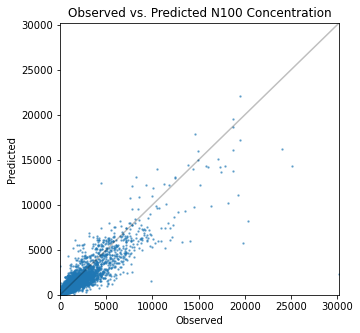

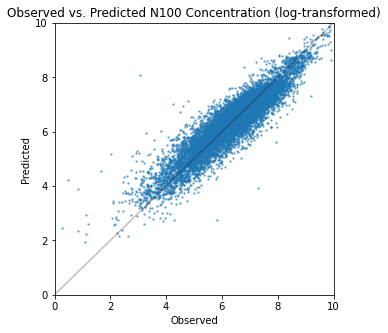

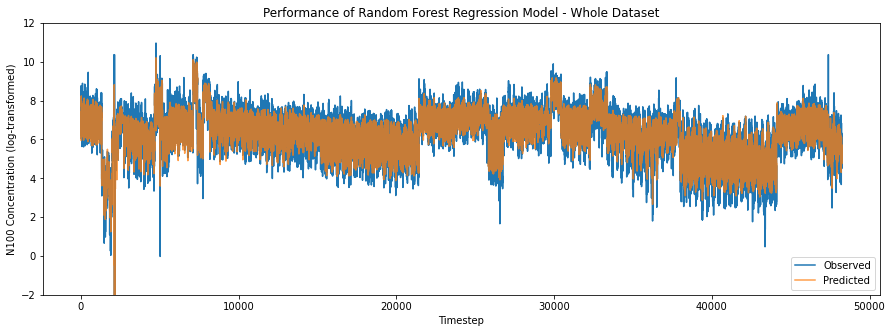

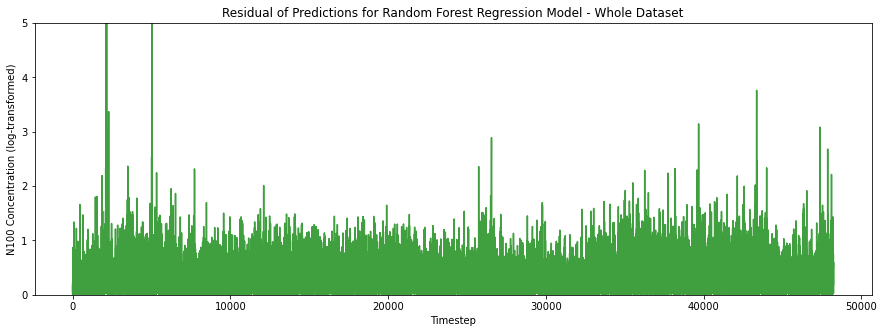

In [16]:
# fitting the random forest regression model
model = RandomForestRegressor(max_depth=10).fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)
log_predictions = None
if log_transf_n100:
    log_predictions = predictions
    predictions = np.exp(predictions)
    predictions[predictions <= 0] = 0.1
else:
    predictions[predictions <= 0] = 0.1
    log_predictions = np.log(predictions)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions)
corr_eval(log_predictions, log_transf=True)

# evaluating the model performance
eval_model(predictions, log_predictions, model)

# making predictions for the whole dataset
predictions_all = model.predict(np.array(data[predictors]))
if not log_transf_n100:
    predictions_all[predictions_all <= 0] = 0.1
    predictions_all = np.log(predictions_all)
        
# plotting the observed and predicted n100 concentrations against time
plot_results('Random Forest Regression', predictions_all, data)
plot_residuals('Random Forest Regression', predictions_all, data)


# RESULTS:
# --------
# predictors for original data
# Correlation between observed and predicted N100 concentration: 0.875
# Correlation between observed and predicted N100 concentration (log-transformed): 0.847
# R2 score on test set: 0.765
# R2 score on test set (log-transformed): 0.671
# RMSE on test set: 751.196
# RMSE on test set (log_transformed): 0.672

# predictors for log-transformed data
# Correlation between observed and predicted N100 concentration: 0.896
# Correlation between observed and predicted N100 concentration (log-transformed): 0.915
# R2 score on test set: 0.790
# R2 score on test set (log-transformed): 0.837
# RMSE on test set: 708.891
# RMSE on test set (log_transformed): 0.473